In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from torch_mist.data.multimixture import MultivariateCorrelatedNormalMixture
from torch_mist.utils import train_mi_estimator
import pandas as pd

sns.set_style('whitegrid')
IMG_SIZE=3
n_dim = 5

train_parameters = dict(
    max_epochs=20,
    batch_size= 64,
    verbose=True,
    valid_percentage=0,
    lr_annealing=False,
    optimizer_params={'lr':5e-4}
)

# Definition of the distribution
p_XY = MultivariateCorrelatedNormalMixture(n_dim=n_dim)

true_mi = p_XY.mutual_information('x','y')

p_Y_given_X = p_XY.conditional('x')
p_Y = p_XY.marginal('y')

In [2]:
samples = p_XY.sample([100000])

# Hybrid mutual information estimation

By combining normalized and unnormalized distributions, we can define a more general class of estimators that can take advantage of the low variance of generative estimators and the flexibility of the discriminative approaches.

We start by defining a variational distribution $q_\theta(y|x)$ as the product of a learnable proposal $r_\theta(y|x)$ and an energy $F_\theta(x,y)$:
$$
q_\theta(y|x) = \frac{r_\theta(y|x) e^{F_\theta(x,y)}}{\int r_\theta(y|x)e^{F_\theta(x,y)}dy}
$$

Using the expression for $q_\theta(y|x)$, we can derive the following estimator:
$$
I(x;y)\le \underbrace{\mathbb{E}_{p(x,y)}\left[\log\frac{r_\theta(y|x)}{p(y)}\right]}_{\text{Generative estimation}} + \underbrace{\mathbb{E}_{p(x,y)}\left[F_\theta(x,y)\right] - \log \mathbb{E}_{p(x)r_\theta(y|x)}\left[e^{F_\theta(x,y)}\right]}_{\text{Discriminative estimation}}.
$$
The first part of the expression is equivalent to the mutual information lower bound obtained with a generative mutual information estimation (e.g. DoE, BA, CLUB,...), while the second component has a similar expression to the discriminative approaches (e.g. MINE, NWJ, SMILE, ...), with one crucial difference.
When computing the partition function (last term), the samples are not drawn from the product distribution $p(x)p(y)$, but from the proposal $p(x)r_\theta(y|x)$ instead.
Whenever $r_\theta(y|x)$ approaches $p(y|x)$, the variance of the estimation for the normalization constant decreases, addressing one of the main issues with discriminative estimators.


In this example we will train a discriminative estimator (`MINE`) and a generative estimator (`DoE`), then show how to combine them to obtain better estimates.


## Generative Estimators: High Bias

One of the main problems of generative mutual information estimation lies in the modeling for $q_\theta(y|x)$ and the approximation of $H(y)$.
In particular lack of flexibility for the model of $q_\theta(y|x)$ yields under-estimation of mutual information.

Here we consider a simple difference of entropies estimator (`DoE`) in which $q_\theta(y|x)$ is modeled with a conditional linear transformation of a Normal distribution, while $r_\psi(y)$ is modeled with a parametric spline transform.

In [3]:
from torch_mist.utils.logging import PandasLogger
from torch_mist.utils.logging.metrics import compute_mean_std

from torch_mist.estimators import doe

estimators = {}
estimators['DoE']=doe(
    x_dim=n_dim,
    y_dim=n_dim,
    hidden_dims=[256, 128],
    conditional_transform_name='conditional_linear',
    marginal_transform_name='spline',
)

# Define a custom logger that computes mean and standard deviation of the log_ratio and batch_loss methods
logger = PandasLogger()
with logger.logged_methods(
    instance=estimators['DoE'],
    methods=[
        ('log_ratio', compute_mean_std),
        ('batch_loss', compute_mean_std)
    ]
):
    doe_log = train_mi_estimator(
        estimator=estimators['DoE'],
        x=samples['x'],
        y=samples['y'],
        logger=logger,
        **train_parameters
    )

doe_log['estimator'] = 'DoE'
log = doe_log

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

We can observe that the `DoE` estimator does not approach the true value of mutual information for this task. This is due to the lack of flexiblity of $q_\theta(y|x)$.

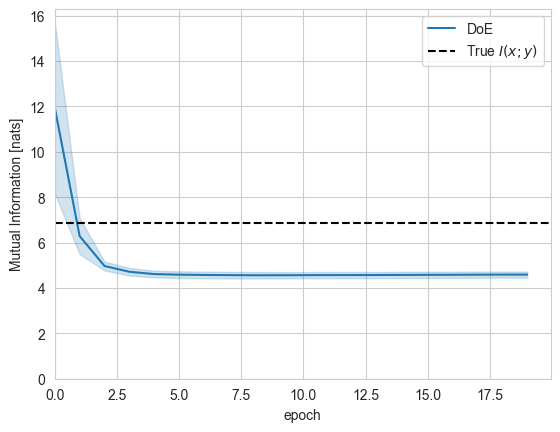

In [8]:
sns.lineplot(log[log['name']=='log_ratio'], x='epoch', y='mean', hue='estimator', ci='sd')
plt.axhline(y=true_mi, ls='--', color='k', label='True $I(x;y)$')
plt.ylim(0,)
plt.xlim(0,)
plt.ylabel('Mutual Information [nats]')
plt.legend();

### Discriminative Estimators: High Variance

If on the one hand generative estimators are generally not powerful enough to match the true ratio, discriminative estimators are affected by high-variance.
We showcase the issues of discriminative mutual information estimators by computing the mean and variance of the estimates for $\log\frac{p(x,y)}{p(x)p(y)}$ within each training batch. 
For this example we use `MINE` mutual information estimator with a `joint_critic` and 1 negative sample for each positive one.

In [9]:
from torch_mist.estimators import mine

estimators['MINE'] = mine(
    x_dim=n_dim,
    y_dim=n_dim,
    hidden_dims=[256, 128],
    neg_samples=1
)

logger = PandasLogger()

with logger.logged_methods(
    instance=estimators['MINE'],
    methods=[
        ('log_ratio', compute_mean_std),
        ('batch_loss', compute_mean_std)
    ]
):
    mine_log = train_mi_estimator(
        estimator=estimators['MINE'],
        x=samples['x'],
        y=samples['y'],
        logger=logger,
        **train_parameters
    )

mine_log['estimator'] = 'MINE'
log = pd.concat([log, mine_log])

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

We can observe that the `MINE` estimator does not approach the true value of mutual information for this task.

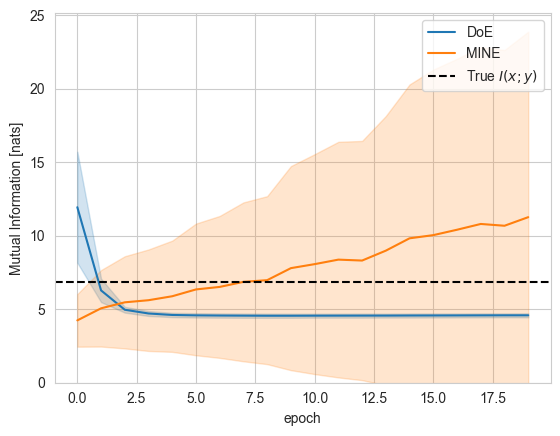

In [10]:
sns.lineplot(log[log['name']=='log_ratio'], x='epoch', y='mean', hue='estimator', ci='sd')
plt.axhline(y=true_mi, ls='--', color='k', label='True $I(x;y)$')
plt.ylim(0,)
plt.ylabel('Mutual Information [nats]')
plt.legend();

Note that the `MINE` estimator has considerable variance for both loss and log-ratio estimation when compared to the generative counterpart.

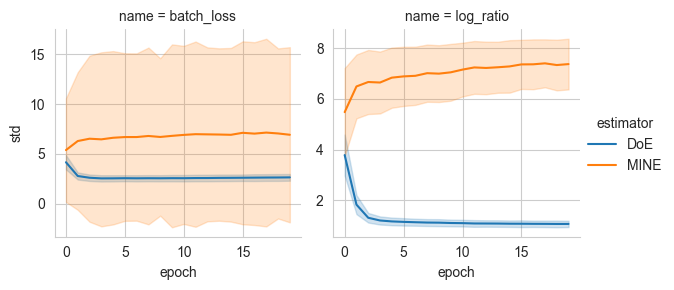

In [14]:
grid = sns.FacetGrid(log, col='name', hue='estimator', sharey=False, sharex=True)
grid.map(sns.lineplot, 'epoch', 'std', ci='sd')
grid.add_legend()

## Combining Mutual Information estimators

Lastly, we show that the two estimators can be combined using the expression above. In particular, we fix the `DoE` estimator and fine-tune the `MINE` to model the ratio between $\log\frac{p(y|x)}{q_\theta(y|x)}$ instead of $\log\frac{p(y|x)}{p(y)}$. This can be easily done by passing the two estimator to the `HybridMIEstimator` class which takes care of combining the estimates, using $q_\theta(y|x)$ instead of $p(y)$ to draw negative samples.

In [15]:
from torch_mist.utils.freeze import freeze
from torch_mist.estimators.hybrid.base import HybridMIEstimator
from copy import deepcopy

estimators['DoE+MINE'] = HybridMIEstimator(
    generative_estimator=freeze(estimators['DoE']),
    discriminative_estimator=deepcopy(estimators['MINE'])
)

logger = PandasLogger()
with logger.logged_methods(
    instance=estimators['DoE+MINE'],
    methods=[
        ('log_ratio', compute_mean_std),
        ('batch_loss', compute_mean_std)
    ]
):
    hybrid_log = train_mi_estimator(
        estimator=estimators['DoE+MINE'],
        x=samples['x'],
        y=samples['y'],
        logger=logger,
        **train_parameters
    )

hybrid_log['estimator'] = 'DoE+MINE'
log = pd.concat([log, hybrid_log])

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

We can see that our hybrid architecture results in much more accurate estimates that slowly approach the ground-truth mutual information value.

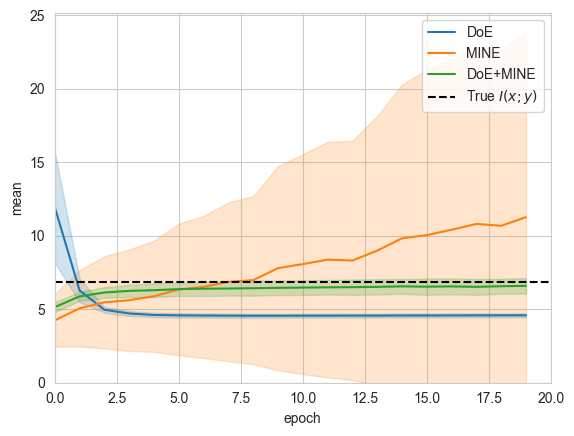

In [18]:
sns.lineplot(log[log['name']=='log_ratio'], x='epoch', y='mean', hue='estimator', errorbar='sd')
plt.axhline(y=true_mi, ls='--', color='k', label='True $I(x;y)$')
plt.ylim(0,)
plt.xlim(0,20)
plt.legend()

The variance of the hybrid `DoE+MINE` estimator is indeed much lower than `MINE`. This is because the variance for the estimation of the log-partition function grows with $e^{KL(p(y|x)||q_\theta(y|x))}$ instead of $e^{KL(p(y|x)||p(y))}$.

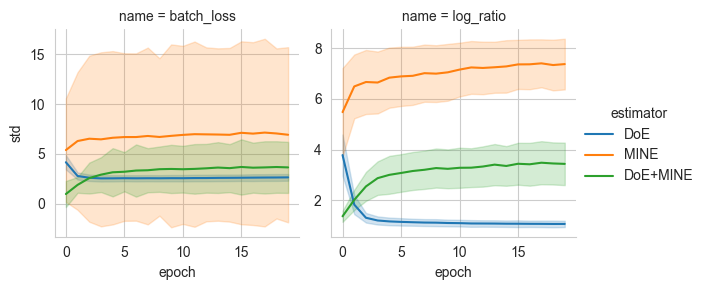

In [17]:
grid = sns.FacetGrid(log, col='name', hue='estimator', sharey=False, sharex=True)
grid.map(sns.lineplot, 'epoch', 'std', ci='sd')
grid.add_legend()

We can further showcase the differences by plotting the modeled log-ratios

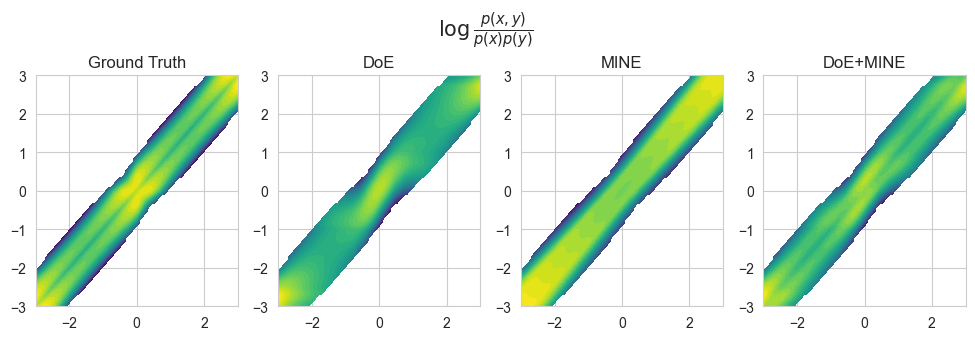

In [19]:
from torch_mist.estimators.generative import GenerativeMIEstimator

# We create a uniform grid to visualize the functions modeled by conditional distributions
res = 100
x_grid = torch.linspace(-3,3,res).view(1,-1,1)
y_grid = torch.linspace(-3,3, res).view(-1,1,1)
X, Y = np.meshgrid(x_grid, y_grid)

# Compute the true log-ratio log p(x,y)p(x)p(y) on the grid
log_marginal = p_XY.marginal('x').log_prob(x=x_grid)/n_dim +  p_XY.marginal('y').log_prob(y=y_grid)/n_dim
log_joint = p_XY.log_prob(x=x_grid, y=y_grid)/n_dim
# We visualize only the points for which p(x,y) > e^{-20}
mask = (log_joint>-25).data.numpy()
log_ratio = (log_joint - log_marginal).data.numpy()


# Plot the true log p(y|x)
f, ax = plt.subplots(
    1,1+len(estimators),
    figsize=((1+len(estimators))*IMG_SIZE, IMG_SIZE)
)

# Plot the true log-ratio
f.suptitle("$\\log \\frac{p(x,y)}{p(x)p(y)}$", fontsize=15, y=1.1)
ax[0].contourf(X, Y, log_ratio/mask, cmap='viridis', levels=40)
ax[0].set_title('Ground Truth')

for i, (name, estimator) in enumerate(estimators.items()):
    if isinstance(estimator, GenerativeMIEstimator):
        log_ratio = estimator.log_ratio(x_grid.repeat(res,1,n_dim), y_grid.repeat(1,res,n_dim)).data.numpy()/n_dim
    else:
        log_ratio = estimator.unnormalized_log_ratio(x_grid.repeat(res,1,n_dim), y_grid.repeat(1,res,n_dim)).data.numpy()/n_dim
        
    ax[i+1].contourf(X, Y, log_ratio/mask, cmap='viridis', levels=40)
    ax[i+1].set_title(name)


It is possible to use the `HybridMIEstimator` class to model combinations of different generative and discriminative estimators (e.g. `BA+SMILE`, `CLUB+JS`, `L1Out+FLO`).